In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
from torch.autograd import Variable 

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [4]:
import gym
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(2, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_hidden)
        self.l3 = nn.Linear(num_hidden, 3)

    def forward(self, x):
        value=self.l2(F.relu(self.l1(x)))
        value=self.l3(F.relu(self.l2(value)))
      #  print(value.shape)
        return value

In [6]:
import random
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory)<self.capacity:
            self.memory.append(transition)
        else:
            del self.memory[0]
            self.memory.append(transition)
        # YOUR CODE HERE
       # raise NotImplementedError()

    def sample(self, batch_size):
        sample=[]
        for i in range(batch_size):
            index = np.random.randint(len(self.memory))
            sample.append(self.memory[index])
        return sample
        # YOUR CODE HERE
       # raise NotImplementedError()

    def __len__(self):
        return len(self.memory)

In [7]:
def get_epsilon(it):
    epsilon = max(1-(1-0.05)/1000*it, 0.05)
    return epsilon

In [8]:
def select_action(model, state, epsilon):
    with torch.no_grad():
        s = torch.from_numpy(state)
        s = s.type(torch.FloatTensor) 
        Q = model(s).numpy()
        policy = np.ones([env.action_space.n])
        policy = policy*epsilon/2
        policy[Q.argmax()] = 1 - epsilon
        action = int(np.random.choice(3, 1, p=policy))
        
    return action

In [9]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    Q = model(state)
   # selected_index=action.reshape(64)

    Q_value = torch.gather(Q, 1, torch.tensor(action).reshape(64,1))
    
   # print(Q_value)
    return Q_value
   # raise NotImplementedError()
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    target=torch.zeros(len(reward))
    for i in range(len(reward)):
        if done[i] == False:
            max_next_state_q = max(model(next_state[i]))
            ind_target = reward[i] + discount_factor*max_next_state_q
            target[i] = ind_target
        else:
            target[i]
   # raise NotImplementedError()
    target = target.reshape(len(reward),1)
    return target

def train(eval_model, target_model, optimizer, batch, discount_factor, loss_func):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(eval_model, state, action)
    
    with torch.enable_grad():  
        target = compute_target(target_model, reward, next_state, done, discount_factor)
       # print(target)
        target = Variable(target, requires_grad=False)
    # loss is measured from error between current and newly expected Q values
    loss = loss_func(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [10]:
def run_episodes(train, eval_dqn, target_dqn, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(eval_dqn.parameters(), learn_rate)
    loss_func = torch.nn.MSELoss()
    num_updates = 0
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    success = 0
    R=[]
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        duration = 0
        
        while done == False:
            accu_reward = 0
            duration +=1 
            epsilon = get_epsilon(global_steps)
            action = select_action(eval_dqn, state, epsilon)
            s_next, reward, done, _ = env.step(action)
            accu_reward+=1
            if done == True:
                if np.absolute(s_next[0]-0.5)<=0.05:
                    success+=1
                
            memory.push((state, action, reward, s_next, done))
            if len(memory.memory) > batch_size:
                minibatch = memory.sample(batch_size)
                train(eval_dqn, target_dqn, optimizer, minibatch, discount_factor, loss_func)
                num_updates = num_updates + 1

            
            if done == True:
                # Update target network
                target_dqn.load_state_dict(eval_dqn.state_dict())
                break
            else:
                state = s_next
                global_steps+=1
        R.append(accu_reward)
            
         #   loss = train(model, memory, optimizer, batch_size, discount_factor)

        episode_durations.append(duration)
        # YOUR CODE HERE
     #   raise NotImplementedError()
    return episode_durations, success, R

In [11]:
# Let's run it!
num_episodes = 500
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(40000)
num_hidden = 20
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

eval_dqn = QNetwork(num_hidden)
target_dqn = QNetwork(num_hidden)

episode_durations, success, reward = run_episodes(train, eval_dqn,target_dqn, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

100%|██████████| 500/500 [17:01<00:00,  2.08s/it]


Text(0.5, 1.0, 'Episode durations per episode')

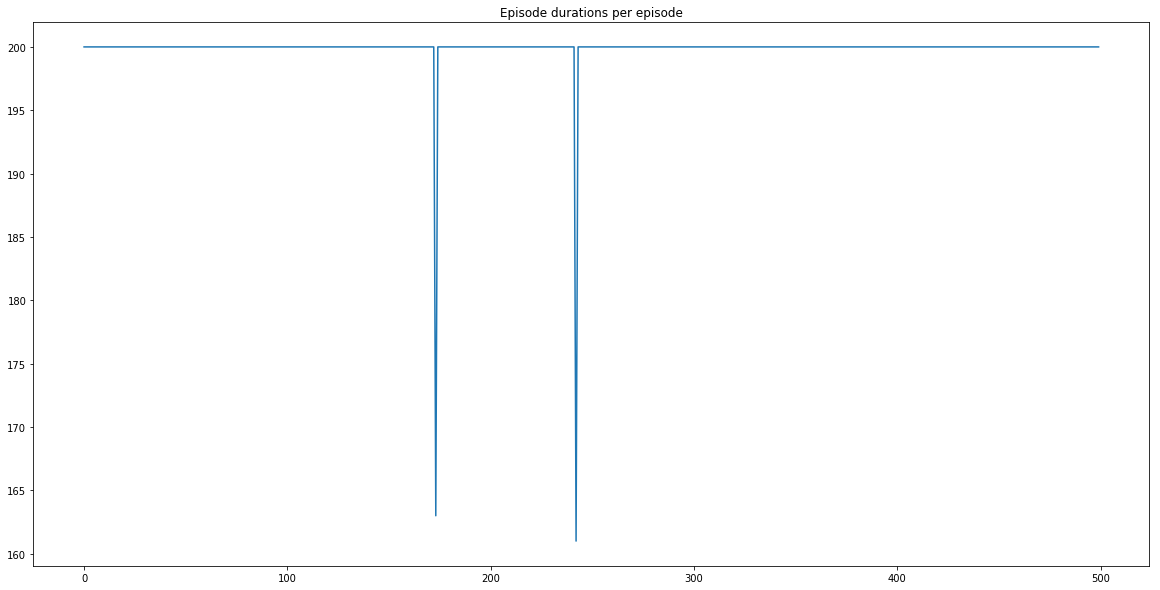

In [12]:
plt.figure(figsize=[20,10])
plt.plot(episode_durations)
plt.title('Episode durations per episode')

In [13]:
success

2